In [18]:
import os
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

# alt.data_transformers.enable('default', max_rows=None)

# Visualize Wi-Fi CSI for human activity

## Supplementary functions

In [19]:
def calibrate_single_phase(phases):
    phases = np.array(phases)
    difference = 0

    calibrated_phase, calibrated_phase_final = np.zeros_like(phases), np.zeros_like(phases)   
    calibrated_phase[0] = phases[0]
    
    phases_len = phases.shape[0]
    
    for i in range(1, phases_len):
        temp = phases[i]- phases[i - 1]
        
        if abs(temp) > np.pi:
            difference = difference + 1*np.sign(temp)
            
        calibrated_phase[i] = phases[i] - difference * 2 * np.pi
        
    k = (calibrated_phase[-1] - calibrated_phase[0]) / (phases_len - 1)
    b = np.mean(calibrated_phase)
    
    for i in range(phases_len):
        calibrated_phase_final[i] = calibrated_phase[i] - k * i - b
        
    return calibrated_phase_final


def calibrate_phase(phases):
    calibated_phases = np.zeros_like(phases)
    
    for i in range(phases.shape[0]):
        calibated_phases[i] = calibrate_single_phase(np.unwrap(phases[i]))
    
    return calibated_phases

def calibrate_amplitude(amplitudes, rssi=1): # Basic statistical normalization
    amplitudes = np.array(amplitudes)    
    return ((amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes))) * rssi

In [7]:
import pywt


def hampel(vals_orig, k=3, t0=123, outliers_return=False):
    vals = pd.Series(vals_orig.copy())

    #Hampel Filter
    L= 1.4826
    
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    vals[outlier_idx]=rolling_median
    
    if outliers_return:
        return vals, outlier_idx

    return vals

def dwn_noise(vals, th=0.19):
    threshold = th # Threshold for filtering

    data = vals.copy()
#     print("data: ", data.shape)

    w = pywt.Wavelet('sym5')
    maxlev = pywt.dwt_max_level(data.shape[0], w.dec_len)
#     print("maximum level is " + str(maxlev))
    
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, 'sym5', level=maxlev)
    
#     plt.figure()
    for i in range(1, len(coeffs)):
#         plt.subplot(maxlev, 1, i)
#         plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
#         plt.plot(coeffs[i])

    datarec = pywt.waverec(coeffs, 'sym5')
    
    return datarec

def noise_reduction_all_subcarriers(amplitudes):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)

    for i in range(amplitudes.shape[1]):
        res[:data_len, i] = dwn_noise(hampel(amplitudes[:, i]))[:data_len]
        
    return res

def hampel_all_subcarriers(amplitudes, k=3, t0=123):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)
    outliers = []

    for i in range(amplitudes.shape[1]):
        res[:data_len, i], out = hampel(amplitudes[:, i], k, t0, True) #[:data_len]
        outliers.append(out)
        
    return res, outliers

def cwt_all_subcarriers(amplitudes, th=0.19):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)
    print("amplitudes.shape[1]",amplitudes.shape[1])
    for i in range(amplitudes.shape[1]):
        res[:data_len, i] = dwn_noise(amplitudes[:, i], th)[:data_len]
        
    return res


def annotation_line( ax, xmin, xmax, y, text, ytext=0, linecolor='black', linewidth=1, fontsize=12 ):

    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data', annotation_clip=False,
            arrowprops={'arrowstyle': '|-|', 'color':linecolor, 'linewidth':linewidth})
    
    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data', annotation_clip=False,
            arrowprops={'arrowstyle': '<->', 'color':linecolor, 'linewidth':linewidth})

    xcenter = xmin + (xmax-xmin)/2
    if ytext == 0:
        ytext = y + ( ax.get_ylim()[1] - ax.get_ylim()[0] ) / 20

    ax.annotate(text, xy=(xcenter,ytext), ha='center', va='center', fontsize=fontsize, annotation_clip=False)

## Load CSI data

In [20]:
def read_csi_data_from_csv(path_to_csv, is_five_hhz=False, antenna_pairs=4):
    data = pd.read_csv(path_to_csv, header=None).values

    if is_five_hhz:
        subcarries_num = SUBCARRIES_NUM_FIVE_HHZ
    else:
        subcarries_num = SUBCARRIES_NUM_TWO_HHZ
    
    data_len = data.shape[0]
    
    amplitudes = data[:, subcarries_num*1:subcarries_num*(1 + antenna_pairs)]
    phases = data[:, subcarries_num*(1 + antenna_pairs):subcarries_num*(1 + 2*antenna_pairs)]
    
    return amplitudes, phases


In [23]:
SUBCARRIES_NUM_TWO_HHZ = 56
SUBCARRIES_NUM_FIVE_HHZ = 114
# path_to_csv="/home/ranjit/Thesis//WIFI_CSI_HAR/dataset/vitalnia_lviv/3/data.csv"
# path_to_csv="/home/ranjit/Thesis//Matlab_Program/Wi_Fi_CSI/updated_dataset/Rx_WiFi_CSI_1.csv"


path_to_csv="/home/ranjit/Thesis/Experiment/CSI_Rx_data/4/data.csv"

experiments_data = []
amplitudes, phases = read_csi_data_from_csv(path_to_csv, False)   

experiments_data.append([amplitudes, phases])

experiments_data=np.asarray(experiments_data) # Convert list to array

# experiments_data=experiments_data[0][0]

# print("amplitude shape",amplitudes.shape)
# print("Phase shape",phases.shape)
# print("experiments_data shape",experiments_data.shape)

print('CSI Amplitude:\n\n',amplitudes)
print("\n\n")
print('CSI Phase:\n\n',phases)

CSI Amplitude:

 [[ 56.          57.          58.         ... 104.         106.28264204
  111.62884932]
 [ 56.          57.          58.         ... 158.54967676 160.55217221
  164.01524319]
 [ 56.          57.          58.         ... 123.68508398 120.35364556
  124.77980606]
 ...
 [ 56.          57.          58.         ... 122.6743657  118.40608092
  118.81077392]
 [ 56.          57.          58.         ... 159.65587994 158.26875876
  157.81318069]
 [ 56.          57.          58.         ... 114.42464769 113.35784049
  111.80339887]]



CSI Phase:

 [[113.26517558 108.6738239  109.48972555 ...  92.96235797  95.35197953
   97.86725704]
 [172.88435441 163.04907237 164.20109622 ... 143.8401891  143.00349646
  145.42695761]
 [124.5351356  123.22743201 118.40608092 ... 106.04244433 105.0809212
  109.73149047]
 ...
 [121.20231021 120.65239326 121.20231021 ... 109.20164834 109.76793703
  113.60017606]
 [165.59287424 158.202402   157.00318468 ... 143.56183337 146.98639393
  142.17243052]


## Features extraction of received CSI data


In [24]:
amplitudes.max()

369.3900377649619

In [25]:
amplitudes.min()

0.0

In [26]:
phases.max()

486.8562416155307

In [27]:
phases.min()

3.1622776601683795

## Mean value

In [28]:
np.mean(amplitudes)

99.83349138121801

In [29]:
np.mean(phases)

149.82554759064968

## Standard Deviation 

In [13]:
np.std(amplitudes)

41.472287277462

In [14]:
np.std(phases)

64.06459585698707

### Amplitude plot

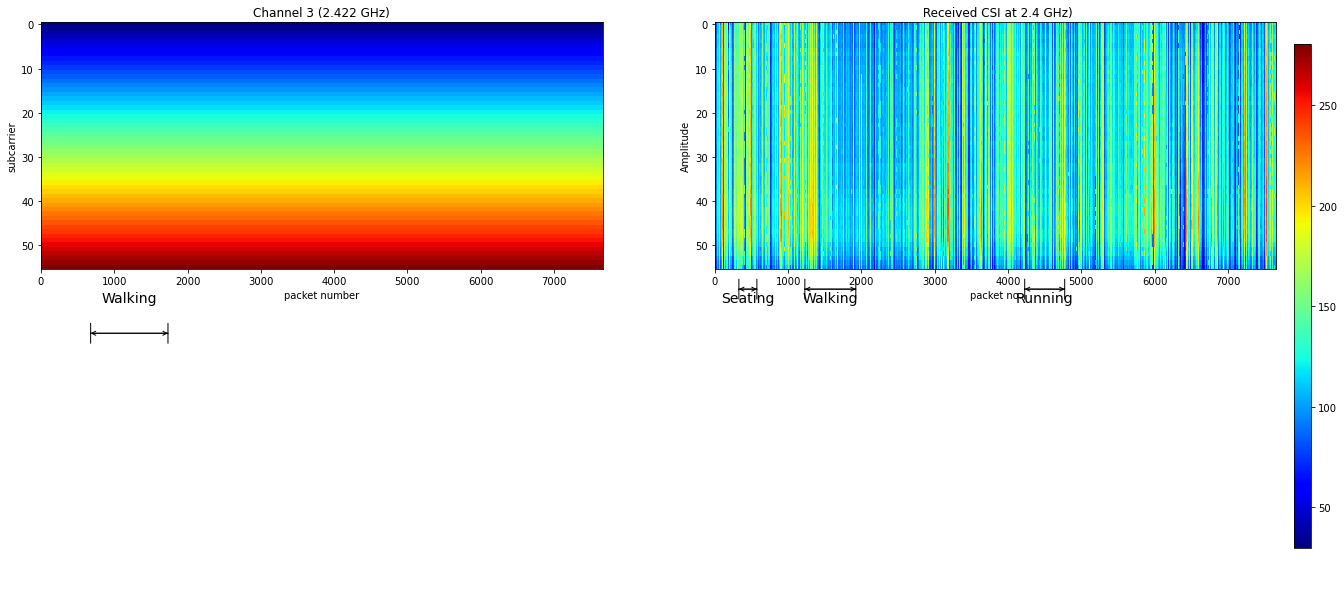

In [30]:
fig = plt.figure(figsize = (24,10))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[0][0][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Channel 3 (2.422 GHz)")
annotation_line(ax=ax1, text='Walking', xmin=650, xmax=1760, y=70, ytext=62, linewidth=1, linecolor='black', fontsize=14)
ax1.set_ylabel('subcarrier')
ax1.set_xlabel('packet number')

ax2 = fig.add_subplot(222)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[0][1][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title(" Received CSI at 2.4 GHz)")

annotation_line(ax=ax2, text='Running', xmin=4200, xmax=4800, y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax2, text='Walking', xmin=1200, xmax=1950, y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)
annotation_line(ax=ax2, text='Seating', xmin=300, xmax=600, y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('packet no.')

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

im = plt.imshow(noise_reduction_all_subcarriers(experiments_data[0][1][:, 0*SUBCARRIES_NUM_TWO_HHZ:1*SUBCARRIES_NUM_TWO_HHZ]).T,interpolation = "nearest", aspect = "auto", cmap="jet")

# fig.suptitle('Channels comparison for 1-to-1 antenna pair (filtered data)', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()
fig.savefig("27.png")

## Data preprocessing

## Loading CSI data

In [12]:
import os
import torch
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader

from data_calibration import calibrate_amplitude_custom, calibrate_phase, calibrate_amplitude, dwn_noise, hampel

SUBCARRIES_NUM_TWO_HHZ = 56
SUBCARRIES_NUM_FIVE_HHZ = 114


def read_csi_data_from_csv(path_to_csv, is_five_hhz=False, antenna_pairs=4):

    data = pd.read_csv(path_to_csv, header=None).values

    if is_five_hhz:
        subcarries_num = SUBCARRIES_NUM_FIVE_HHZ
    else:
        subcarries_num = SUBCARRIES_NUM_TWO_HHZ

    # 1 -> to skip subcarriers numbers in data
    amplitudes = data[:, subcarries_num * 1:subcarries_num * (1 + antenna_pairs)]
    phases = data[:, subcarries_num * (1 + antenna_pairs):subcarries_num * (1 + 2 * antenna_pairs)]

    return amplitudes, phases

def read_labels_from_csv(path_to_csv):
    data = pd.read_csv(path_to_csv, header=None).values
    labels = data[:, 1]
    return labels

def read_all_data_from_files(paths, is_five_hhz=True, antenna_pairs=4):

    final_amplitudes, final_phases, final_labels = np.empty((0, antenna_pairs * SUBCARRIES_NUM_FIVE_HHZ)), \
                                                   np.empty((0, antenna_pairs * SUBCARRIES_NUM_FIVE_HHZ)), \
                                                   np.empty((0))
    for index, path in enumerate(paths):
        amplitudes, phases = read_csi_data_from_csv(os.path.join(path, "data.csv"), is_five_hhz, antenna_pairs)
        labels = read_labels_from_csv(os.path.join(path, "label.csv"))

        amplitudes, phases = amplitudes[:-1], phases[:-1]  # fix the bug with the last element

        final_amplitudes = np.concatenate((final_amplitudes, amplitudes))
        final_phases = np.concatenate((final_phases, phases))
        final_labels = np.concatenate((final_labels, labels))

    return final_amplitudes, final_phases, final_labels


def read_all_data(is_five_hhz=True, antenna_pairs=4):
    all_paths = []

    for index, room in enumerate(DATA_ROOMS):
        for subroom in DATA_SUBROOMS[index]:
            all_paths.append(os.path.join(DATASET_FOLDER, room, subroom))

    return read_all_data_from_files(all_paths, is_five_hhz, antenna_pairs)


"""CSI Dataset."""

class CSIDataset(Dataset):
    
    def __init__(self, csv_files, window_size=32, step=1):
        from sklearn import decomposition

        self.amplitudes, self.phases, self.labels = read_all_data_from_files(csv_files)

        self.amplitudes = calibrate_amplitude(self.amplitudes)

        pca = decomposition.PCA(n_components=3)
        self.amplitudes_pca = []

        data_len = self.phases.shape[0]
        for i in range(self.phases.shape[1]):
            self.amplitudes[:data_len, i] = dwn_noise(hampel(self.amplitudes[:, i]))[:data_len]

        for i in range(4):
            self.amplitudes_pca.append(
                pca.fit_transform(self.amplitudes[:, i * SUBCARRIES_NUM_FIVE_HHZ:(i + 1) * SUBCARRIES_NUM_FIVE_HHZ]))
        self.amplitudes_pca = np.array(self.amplitudes_pca)
        self.amplitudes_pca = self.amplitudes_pca.reshape((self.amplitudes_pca.shape[1], self.amplitudes_pca.shape[0] * self.amplitudes_pca.shape[2]))

        self.label_keys = list(set(self.labels))
        self.class_to_idx = {
            "standing": 0,
            "walking": 1,
            "get_down": 2,
            "sitting": 3,
            "get_up": 4,
            "lying": 5,
            "no_person": 6
        }
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        self.window = window_size
        if window_size == -1:
            self.window = self.labels.shape[0] - 1

        self.step = step

    def __getitem__(self, idx):
        if self.window == 0:
            return np.append(self.amplitudes[idx], self.phases[idx]), self.class_to_idx[
                self.labels[idx + self.window - 1]]

        idx = idx * self.step
        all_xs, all_ys = [], []

        for index in range(idx, idx + self.window):
            all_xs.append(np.append(self.amplitudes[index], self.amplitudes_pca[index]))

        return np.array(all_xs), self.class_to_idx[self.labels[idx + self.window - 1]]

    def __len__(self):
        return int((self.labels.shape[0] - self.window) // self.step) + 1


if __name__ == '__main__':
    CSI_dataset = CSIDataset(["/home/ranjit/Thesis/Experiment/CSI_Rx_data/4",])
    print(CSI_dataset[0])

    

(array([[ 0.07470731,  0.08836628,  0.09543154, ...,  0.30329625,
        -0.53365213, -0.17922653],
       [ 0.0744067 ,  0.08772772,  0.09518776, ...,  0.32258778,
        -0.52110809, -0.17941407],
       [ 0.07397292,  0.08704143,  0.09452385, ...,  0.35364775,
        -0.57204909, -0.16663591],
       ...,
       [ 0.07666116,  0.08193209,  0.09336206, ...,  0.76617262,
         0.69133238, -0.19055042],
       [ 0.07281383,  0.08247631,  0.09353142, ...,  0.70823822,
         0.36849507, -0.18540065],
       [ 0.07682622,  0.08444508,  0.09476643, ...,  0.80733552,
         0.27985573, -0.20640023]]), 1)


## Collection of CSI data amplitude and phase

In [13]:
dataset = CSIDataset(["/home/ranjit/Thesis/Experiment/CSI_Rx_data/4",], window_size=-1)
dataset_amp = dataset[0][0][:, 0:456]
dataset_amp.shape
print(dataset_amp)

[[0.07470731 0.08836628 0.09543154 ... 0.14303649 0.13033275 0.11560539]
 [0.0744067  0.08772772 0.09518776 ... 0.21318523 0.19916877 0.18876109]
 [0.07397292 0.08704143 0.09452385 ... 0.17307186 0.16005833 0.14702229]
 ...
 [0.11966088 0.13133261 0.14202642 ... 0.15753244 0.15005715 0.13911613]
 [0.11900901 0.12750171 0.13850049 ... 0.15739978 0.14983502 0.13884962]
 [0.13668649 0.15217852 0.1661674  ... 0.16176916 0.15231549 0.14024762]]


## Noise Reduction using Hampler algorithm

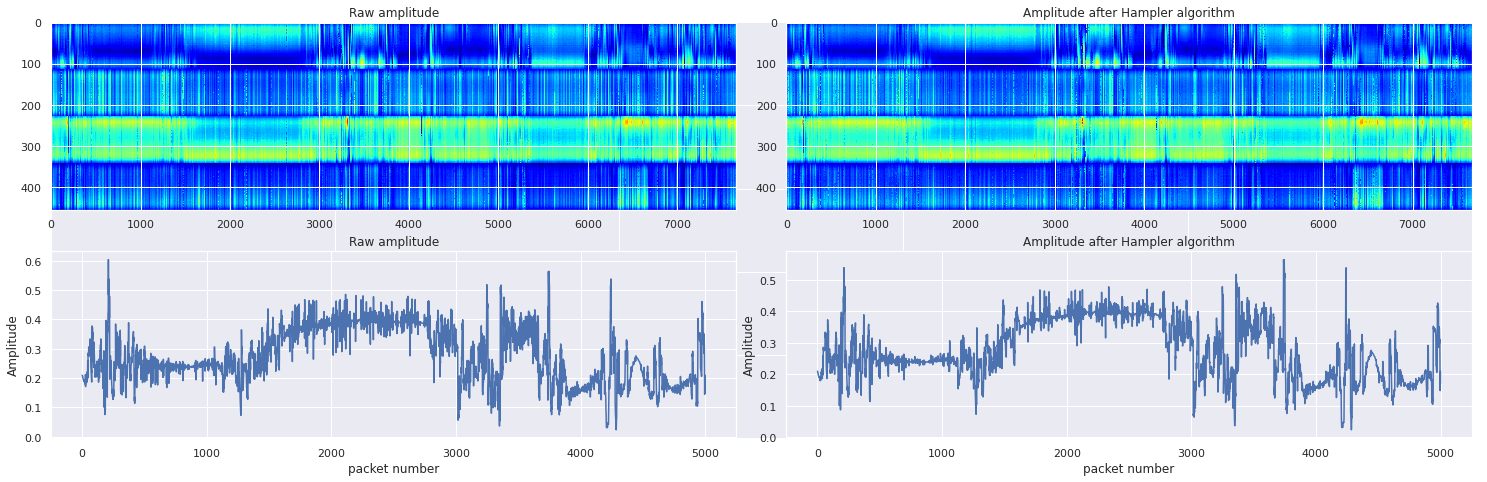

In [18]:
import seaborn as sns

fig = plt.figure(figsize = (21, 7))
ax = fig.add_subplot(111)

h_amplitude, outliers = hampel_all_subcarriers(dataset_amp, k=5, t0=2)

ax1 = fig.add_subplot(221)
im = plt.imshow((dataset_amp).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw amplitude")

ax2 = fig.add_subplot(222)
im = plt.imshow(h_amplitude.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Amplitude after Hampler algorithm")

ax3 = fig.add_subplot(223)
plt.plot(dataset_amp[0:5000, 20])
ax3.set_title("Raw amplitude")

ax4 = fig.add_subplot(224)
plt.plot(h_amplitude[0:5000, 20])
ax4.set_title("Amplitude after Hampler algorithm")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax3.set_ylabel('Amplitude')
ax4.set_ylabel('Amplitude')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.tight_layout(pad=0.5)
plt.show()

fig.savefig("25a.png")

### Noise reduction using CWT

amplitudes.shape[1] 456


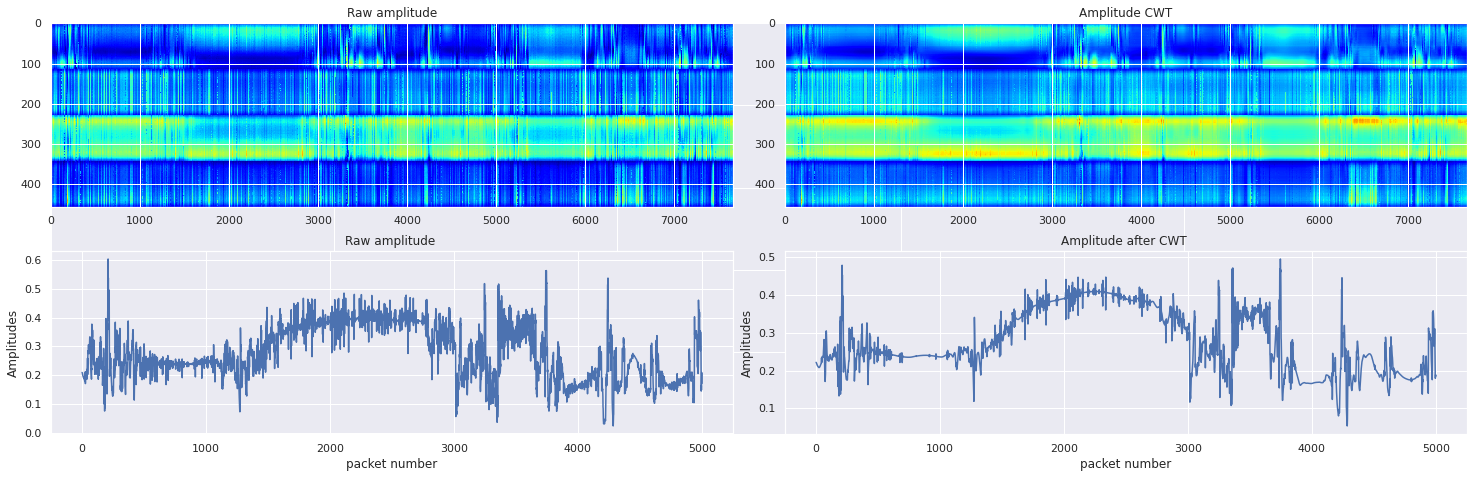

In [19]:
fig = plt.figure(figsize = (21, 7))
ax = fig.add_subplot(111)
cwt_amplitude = cwt_all_subcarriers(dataset_amp, th=0.2)

ax1 = fig.add_subplot(221)
im = plt.imshow((dataset_amp).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw amplitude")

ax2 = fig.add_subplot(222)
im = plt.imshow(cwt_amplitude.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Amplitude CWT")

ax3 = fig.add_subplot(223)
plt.plot(dataset_amp[0:5000, 20])
ax3.set_title("Raw amplitude ") # (subcarrier = 20, range from 4000 to 5000 packet)

ax4 = fig.add_subplot(224)
plt.plot(cwt_amplitude[0:5000, 20])
ax4.set_title("Amplitude after CWT ") # (subcarrier = 20, range from 4000 to 5000 packet)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax3.set_ylabel('Amplitudes')
ax4.set_ylabel('Amplitudes')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.tight_layout(pad=0.7)
plt.show()

fig.savefig("25b.png")

## Compare HAMPLER Vs DWT Noise removal

(7661, 456)
(7661,)
(7662,)


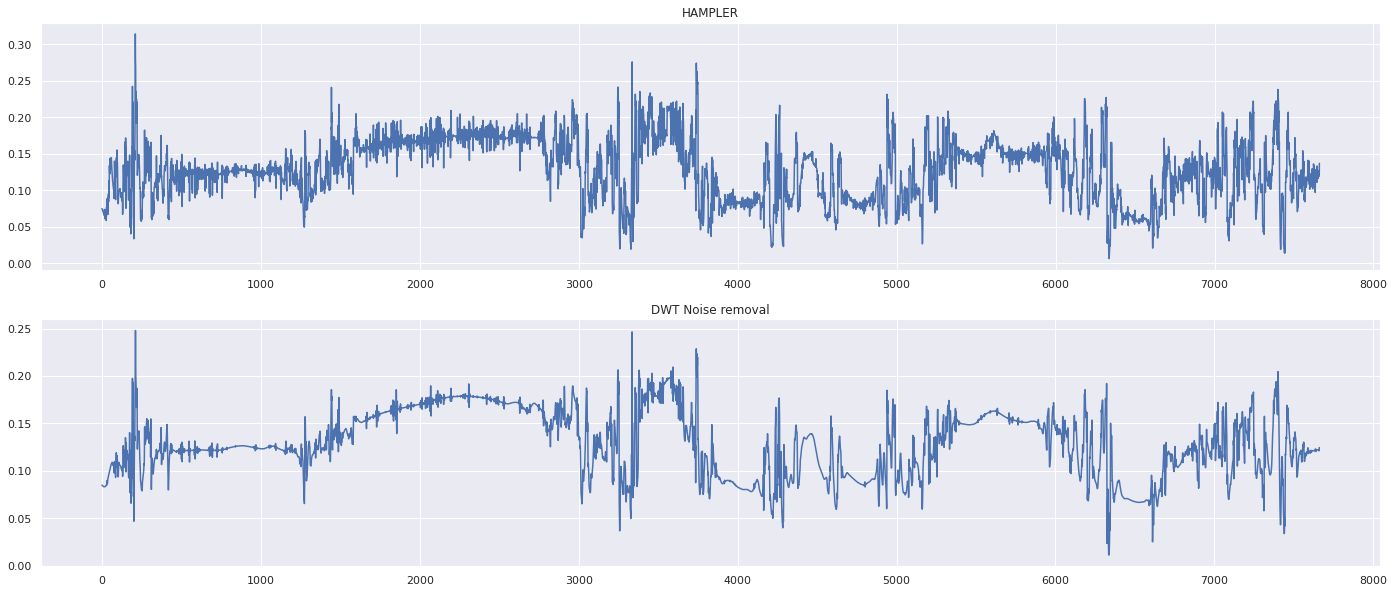

In [20]:

amp1=dataset_amp

amp1_without_outliers = hampel(amp1.T[0])
amp1_with_dwt = dwn_noise(amp1_without_outliers)

print(amp1.shape)
print(amp1_without_outliers.shape)
print(amp1_with_dwt.shape)

fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(211)
plt.plot(amp1_without_outliers)
ax1.set_title("HAMPLER")

ax2 = plt.subplot(212)
plt.plot(amp1_with_dwt)
ax2.set_title("DWT Noise removal")
fig.savefig("25c.png")

## HAMPLER Algorithm amp with and without outliers

In [ ]:
dataset_amp = dataset[0][0][300:1500, 0:456]
amp1 = dataset_amp[:, 0:SUBCARRIES_NUM_FIVE_HHZ]
amp1_without_outliers = hampel(amp1[:, 0])

print(amp1_without_outliers.to_numpy())

fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(211)
plt.plot(amp1.T[0])


ax1.set_title("Raw data")

ax2 = plt.subplot(212)
plt.plot(amp1_without_outliers)
ax2.set_title("HAMPLER algo")


## Add PCA to CSI dataset

amp1_pca:  (7661, 3)
amp1_pca.T:  (3, 7661)


Text(0.5, 1.0, 'PCA3')

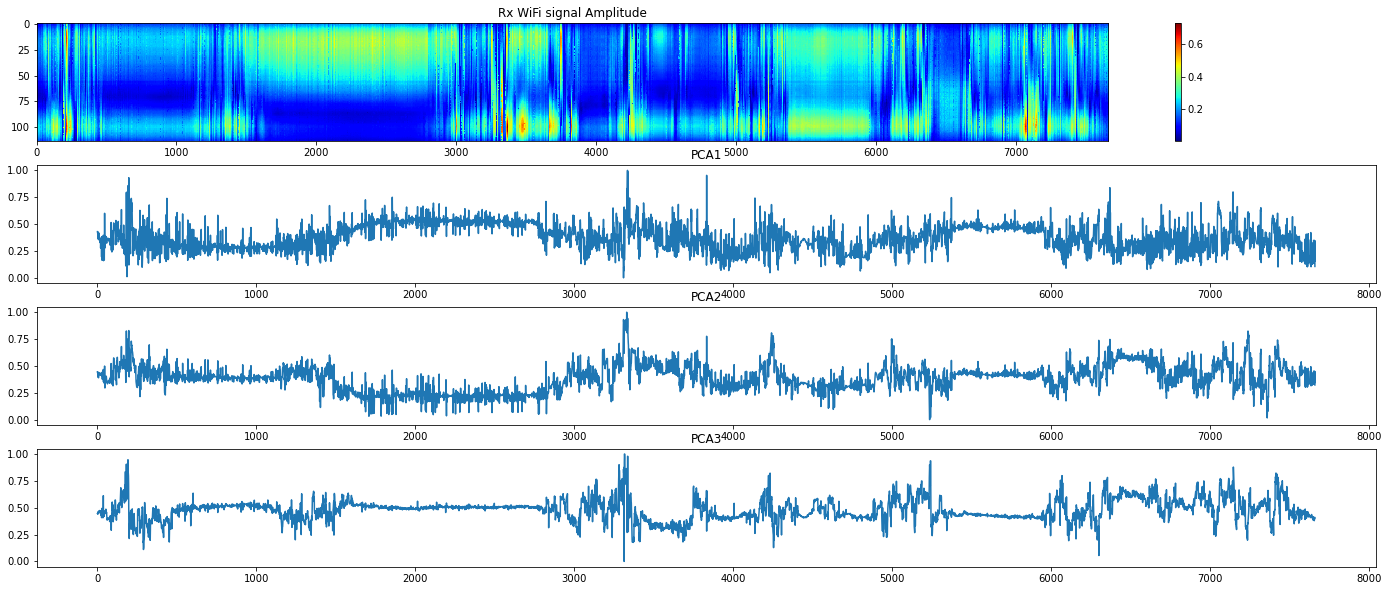

In [149]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)

dataset_amp = dataset[0][0][:, 0:456]
dataset_phase = dataset[0][0][:, 456:]
dataset_labels = dataset[0][1]

fig = plt.figure(figsize = (24,10))
ax1 = plt.subplot(411)
plt.imshow(dataset_amp[:,0*SUBCARRIES_NUM_FIVE_HHZ:1*SUBCARRIES_NUM_FIVE_HHZ].T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Rx WiFi signal Amplitude")
plt.colorbar()

amp1_pca = pca.fit_transform(dataset_amp[:,2*SUBCARRIES_NUM_FIVE_HHZ:3*SUBCARRIES_NUM_FIVE_HHZ])

print("amp1_pca: ", amp1_pca.shape)
print("amp1_pca.T: ", amp1_pca.T.shape)

ax2 = plt.subplot(412)
plt.plot(calibrate_amplitude(amp1_pca.T[0], 1))
ax2.set_title("PCA1")


ax3 = plt.subplot(413)
plt.plot(calibrate_amplitude(amp1_pca.T[1], 1))
ax3.set_title("PCA2")


ax4 = plt.subplot(414)
plt.plot(calibrate_amplitude(amp1_pca.T[2], 1))
ax4.set_title("PCA3")